In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/TEM_Rebuttal_Files/

/content/drive/MyDrive/TEM_Rebuttal_Files


In [ ]:
from skimage.transform import resize
import numpy as np
import cv2
import tifffile
from scipy import ndimage as nd
from keras.utils import normalize
import os
from PIL import Image
from matplotlib import pyplot as plt
from skimage import measure, color, io
import tensorflow as tf
from tqdm.auto import tqdm

# Custom Metric

In [ ]:
import csv

results = []
with open("factor.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        results.append(row)
factor=np.array(results)

In [ ]:
def fft_generator(img):
    #FFT Generation
    r = img.shape[0]
    f = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft = np.fft.fft2(img)
    dft_shift = np.fft.fftshift(dft)
    f_shift = np.fft.fftshift(f)
    f_complex = f_shift[:,:,0] + 1j*f_shift[:,:,1]
    f_abs = np.abs(f_complex) + 1 # lie between 1 and 1e6
    f_bounded = 20 * np.log(f_abs)
    f_img = 255 * f_bounded / np.max(f_bounded)
    f_img = f_img.astype(np.uint8)
    #FFT End
    if(r > 2048):
        f_img=f_img[int(r/4):int((3*r)/4),int(r/4):int((3*r)/4)]
    return f_img, dft_shift

def fft_denoising(f_img, factor, tweak_image=True, blur=True):
    #FFT denoising
    r = int(f_img.shape[0] // 2)
    a= np.array(f_img[r:r+int((8*r)/3), r:r+int((8*r)/3)])
    s = a.mean()

    f_img=np.subtract(f_img,s)
    f_img = f_img.clip(min=0)
    factor = np.resize(factor,np.array(f_img).shape)
    f_img = np.multiply(f_img, factor)
    f_img = f_img.astype(int)
    maxi = f_img.max()
    maxmult = 255/maxi
    f_img = f_img*maxmult

    if tweak_image == True:
        alpha = 3 # Contrast control (1.0-3.0)
        beta = 11 # Brightness control (0-100)
        f_img = cv2.convertScaleAbs(f_img, alpha=alpha, beta=beta)
    if blur:
        f_img = nd.gaussian_filter(f_img, sigma=3)
    return f_img

In [ ]:
def pre_process_data(image, output_shape=(1024, 512)):
    if image.shape[0] == image.shape[1]:
        resize_output_shape = (output_shape[0], output_shape[0])
    else:
        resize_output_shape = (output_shape[0], output_shape[1])
    image = resize(
        image,
        output_shape=resize_output_shape,
        preserve_range=True
    )

    return image[:, :output_shape[1]]

In [ ]:
def image_preprocessor(image_path, raw=True, output_shape=(1024, 512)):
    # Load TEM image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = np.array(image)

    if raw:
        # Generate raw fft
        image, dft_shift = fft_generator(image)

        # generate and save pristine fft without blurring
        image = fft_denoising(image, factor, blur=False)
        cv2.imwrite('raw_fft.png', image)
    # blur fft image
    image = nd.gaussian_filter(image, sigma=3)

    # crop fft in half and save it
    fft_half = pre_process_data(image, output_shape=output_shape)

    cv2.imwrite('temp.png', fft_half, )
    # read back half fft with 3 channels
    fft_half = cv2.imread('temp.png')

    # # delete temporary fft image
    # os.remove('temp.png')

    return fft_half

### Preprocess test data

In [ ]:
OUTPUT_SHAPE = (1024, 512)

In [ ]:
# load TEM image
i = 1
image_path = f"Sample_Data/images/{i}.png"

fft_half =image_preprocessor(image_path, output_shape=OUTPUT_SHAPE)

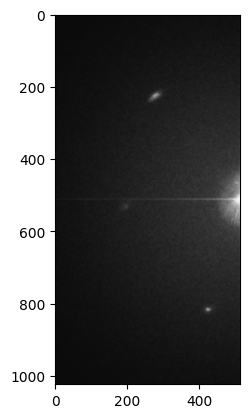

In [ ]:
plt.imshow(fft_half, cmap='gray')

In [ ]:
base_path = 'Sample_Data/Test_Folder/FFT'

test_data = []

for i in range(1, 10):
    image_path = f"{base_path}/{i}.png"
    fft_image = image_preprocessor(image_path, raw=False, output_shape=OUTPUT_SHAPE)
    test_data.append(fft_image)
test_data = np.array(test_data)

In [ ]:
!ls Sample_Data/Test_Folder/Mask
mask_path = 'Sample_Data/Test_Folder/Mask'

ground_truth = []

for i in range(1, 10):
    image_path = f"{mask_path}/{i}.png"
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = np.array(mask)
    mask = pre_process_data(mask, output_shape=OUTPUT_SHAPE)
    mask = np.around(mask / 255)
    ground_truth.append(mask)
ground_truth = np.array(ground_truth)
ground_truth = ground_truth.astype(np.int64, copy=False)

1.png  2.png  3.png  4.png  5.png  6.png  7.png  8.png	9.png


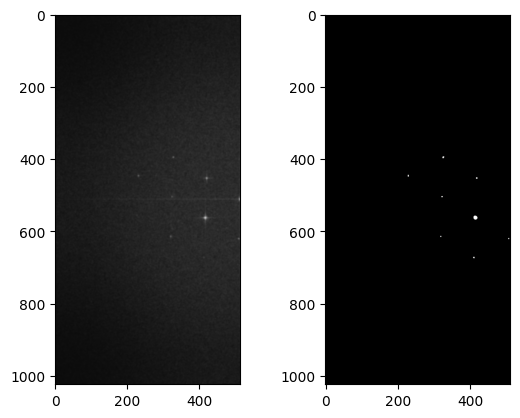

In [ ]:
i = 8
plt.subplot(1, 2, 1)
plt.imshow(test_data[i], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(ground_truth[i], cmap='gray')

In [ ]:
assert test_data.shape[1:] == (*OUTPUT_SHAPE, 3)
assert ground_truth.shape[1:] == OUTPUT_SHAPE

In [ ]:
np.save(f'Sample_Data/Test_Folder/test_data_{OUTPUT_SHAPE[0]}.npy', test_data)
np.save(f'Sample_Data/Test_Folder/ground_truth_{OUTPUT_SHAPE[0]}.npy', ground_truth)

In [ ]:
ground_truth[0].max()

1

### Validation Data

In [ ]:
OUTPUT_SHAPE = (1024, 512)

In [ ]:
base_path = 'Sample_Data/valid/fft'

valid_data = []

for i in sorted(os.listdir(base_path)):
    image_path = f"{base_path}/{i}"
    print(image_path)
    image = cv2.imread(image_path)
    image = np.array(image)
    image = resize(image, output_shape=OUTPUT_SHAPE) # pre_process_data(image, output_shape=OUTPUT_SHAPE)
    valid_data.append(image)

valid_data = np.array(valid_data)

Sample_Data/valid/fft/15.png
Sample_Data/valid/fft/19.png
Sample_Data/valid/fft/21.png
Sample_Data/valid/fft/23.png
Sample_Data/valid/fft/29.png
Sample_Data/valid/fft/39.png
Sample_Data/valid/fft/43.png
Sample_Data/valid/fft/52.png
Sample_Data/valid/fft/59.png
Sample_Data/valid/fft/8.png


In [ ]:
mask_path = 'Sample_Data/valid/gt'

valid_ground_truth = []

for i in sorted(os.listdir(mask_path)):
    image_path = f"{mask_path}/{i}"
    print(image_path)
    mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = np.array(mask)
    mask = pre_process_data(mask, output_shape=OUTPUT_SHAPE)
    mask = np.around(mask / 255)
    valid_ground_truth.append(mask)
valid_ground_truth = np.array(valid_ground_truth)
valid_ground_truth = valid_ground_truth.astype(np.int64, copy=False)

Sample_Data/valid/gt/15.tif
Sample_Data/valid/gt/19.tif
Sample_Data/valid/gt/21.tif
Sample_Data/valid/gt/23.tif
Sample_Data/valid/gt/29.tif
Sample_Data/valid/gt/39.tif
Sample_Data/valid/gt/43.tif
Sample_Data/valid/gt/52.tif
Sample_Data/valid/gt/59.tif
Sample_Data/valid/gt/8.tif


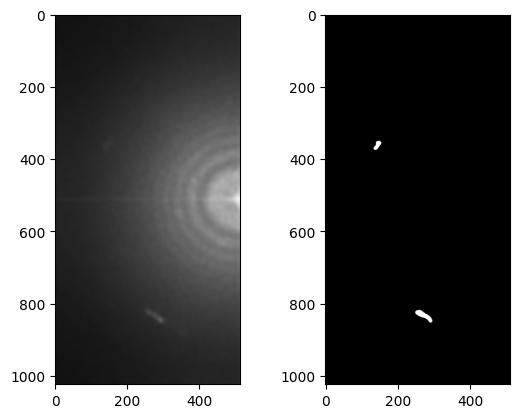

In [ ]:
i = 8
plt.subplot(1, 2, 1)
plt.imshow(valid_data[i], cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(valid_ground_truth[i], cmap='gray')

In [ ]:
np.save(f'Sample_Data/Test_Folder/valid_data_{OUTPUT_SHAPE[0]}.npy', valid_data)
np.save(f'Sample_Data/Test_Folder/valid_ground_truth_{OUTPUT_SHAPE[0]}.npy', valid_ground_truth)

### Load Model

#### Original

In [ ]:
IMG_HEIGHT = 1024
IMG_WIDTH  = 512
IMG_CHANNELS = 3

In [ ]:
model_name = "Unet"
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

nfilters = 1024

dropout_vals = [0.1, 0.1, 0.2, 0.2, 0.3]
contracting_layers = []

# Contraction path
x = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
for j, filters in enumerate([int(nfilters/8), int(nfilters/4), int(nfilters/2), int(nfilters), int(nfilters*2)]):
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = tf.keras.layers.Dropout(dropout_vals[j])(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    contracting_layers.append(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x) if j < 4 else x

# Expansive path
for j, filters in enumerate([int(nfilters), int(nfilters/2), int(nfilters/4), int(nfilters/8)]):
    x = tf.keras.layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.concatenate([x, contracting_layers[-(j+2)]])
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = tf.keras.layers.Dropout(dropout_vals[-(j+2)])(x)
    x = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

In [ ]:
def dice_coefficient(y_true, y_pred):
    # Flatten the tensors
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.reshape(y_pred, [-1])

    # Compute the intersection and the sum of the two tensors
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    # Compute Dice Coefficient
    dice = (2. * intersection + 1e-5) / (union + 1e-5)

    return dice

fmodel = tf.keras.Model(inputs=[inputs], outputs=[outputs])
fmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coefficient])
fmodel.optimizer.lr=0.0001

fmodel.load_weights('models/Unet/model_1024_prec_6_dc_0.7557_l_0.0396.hdf5')

#### Tuned

In [ ]:
!ls 'models/Unet/1024x512'

artifacts				     unet_filters_256_loss_1.h5
combined_loss				     unet_filters_256_loss.h5
unet_filters_256_dc_0.5932_l_0.0040.h5	     unet_filters_512_dc_0.5269_l_0.0033_loss.h5
unet_filters_256_dc_0.5952_l_0.0039_loss.h5  unet_filters_512_dc_0.6372_l_0.0040_loss.h5
unet_filters_256_dc_0.6543_l_0.0060.h5	     unet_filters_512_dc_0.6372_l_0.0048.h5
unet_filters_256_dc_0.6589_l_0.0052.h5	     unet_filters_512_dc_0.6512_l_0.0039.h5
unet_filters_256_dc_0.6635_l_0.0073.h5	     unet_filters_512_dc_0.6545_l_0.0055.h5


1/1 [==============================] - 4s 4s/step


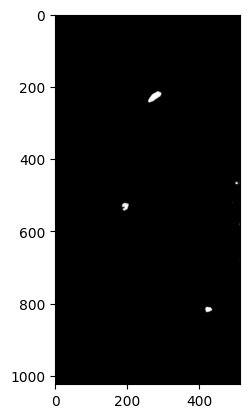

In [ ]:
def dice_coefficient(y_true, y_pred):
    # Flatten the tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    # Compute the intersection and the sum of the two tensors
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    # Compute Dice Coefficient
    dice = (2. * intersection + 1e-5) / (union + 1e-5)

    return dice
model_path = 'models/Unet/1024x512'
model_name = 'unet_filters_512_dc_0.6545_l_0.0055'
fmodel = tf.keras.models.load_model(
    f'{model_path}/{model_name}.h5',
    custom_objects={"dice_coefficient": dice_coefficient},
)
fpred = fmodel.predict(fft_half[np.newaxis, ...])
plt.imshow(fpred[0], cmap='gray')

### Generate Segmentation


#### Setup

In [ ]:
dimension_factor = 4096

In [ ]:
import math
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def unique(list1):

    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return unique_list

In [ ]:
from scipy.signal import find_peaks
import scipy.fftpack as fp
import tensorflow as tf
import pandas as pd
def radial_profile(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    parts = 1
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    tbin=tbin[0:center[0]]
    tbin_r = tbin[0::parts]
    for i in range(1,parts):
        tbin_r=tbin_r + tbin[i::parts]
    #tbin_r = tbin[0::16]+tbin[1::16]+tbin[2::16]+tbin[3::16]+tbin[4::16]+tbin[5::16]+tbin[6::16]+tbin[7::16]
    radialprofile = tbin_r
    return radialprofile

def radial_profile_avg(data, center):
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    parts=1
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    tbin=tbin[0:center[0]]
    tbin_r = tbin[0::parts]
    for i in range(1,parts):
        tbin_r=tbin_r + tbin[i::parts]
    #tbin_r = tbin[0::8]+tbin[1::8]+tbin[2::8]+tbin[3::8]+tbin[4::8]+tbin[5::8]+tbin[6::8]+tbin[7::8]
    nr=nr[0:center[0]]
    nr_r = nr[0::parts]
    for i in range(1,parts):
        nr_r=nr_r + nr[i::parts]
    #nr_r = nr[0::8]+nr[1::8]+nr[2::8]+nr[3::8]+nr[4::8]+nr[5::8]+nr[6::8]+nr[7::8]
    radialprofile = tbin_r/nr_r
    return radialprofile

def r2d(radius,pxsize,r,divs):
    d = radius/10
    return 1/((d*((r+1)/2))/(pxsize*r*2*divs))

In [ ]:
df = pd.read_csv('database.csv',header=None)
dirpath = 'Sample_Data'

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def getcomponent(y):
    x=float(y)*10
    component = str(list(df.loc[df[2]==find_nearest(np.array(df[2]),x)][0])[0]) +' '+ str(list(df.loc[df[2]==find_nearest(np.array(df[2]),x)][1])[0])
    return component

In [ ]:
def PlotGraph(imgname, pxsize, f_shift, df, framecount,
              predicted_mask='temp.png', masked_fft='masked_fft.png', eval=False):
    from tensorflow.python.framework import ops
    ops.reset_default_graph()

    #### WATERSHED SEGMENTATION
    img = cv2.imread(predicted_mask)
    img_grey = img[:,:,0]

    ## transform the unet result to binary image
    #Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
    ret1, thresh = cv2.threshold(img_grey, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


    # Morphological operations to remove small noise - opening
    #To remove holes we can use closing
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    #Watershed should find this area for us.
    sure_bg = cv2.dilate(opening,kernel,iterations=10)
    # Finding sure foreground area using distance transform and thresholding
    #intensities of the points inside the foreground regions are changed to
    #distance their respective distances from the closest 0 value (boundary).
    #https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)


    #Let us threshold the dist transform by starting at 1/2 its max value.
    ret2, sure_fg = cv2.threshold(dist_transform, 0.1*dist_transform.max(),255,0)

    #Later you may realize that 0.2*max value may be better. Also try other values.
    #High value like 0.7 will drop some small mitochondria.

    # Unknown ambiguous region is nothing but bkground - foreground
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)


    ###Ganesh: JUST REPLACE sure_fg with the image
    ret3, markers = cv2.connectedComponents(img_grey)
    markers = markers+10

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0
    #plt.imshow(markers, cmap='gray')   #Look at the 3 distinct regions.

    #Now we are ready for watershed filling.
    markers = cv2.watershed(img, markers)
    img[markers == -1] = [0,255,255]

    img2 = color.label2rgb(markers, bg_label=0)
    props = measure.regionprops_table(markers, intensity_image=img_grey,
                              properties=['label',
                                          'centroid','axis_major_length',
                                                 'axis_minor_length'])
    dfp = pd.DataFrame(props)

    dfp=dfp[1:]
    dfp['distance'] = [np.sqrt((list(dfp['centroid-0'])[i]-511.5)*(list(dfp['centroid-0'])[i]-511.5)+(list(dfp['centroid-1'])[i]-511.5)*(list(dfp['centroid-1'])[i]-511.5)) for i in range(0,len(dfp))]
    pxsize_actual = (1/(dimension_factor*pxsize))*(2)
    #pxsize_actual = (1/(dimension_factor*pxsize))
    print(pxsize_actual)
    dfp['dspacing'] = [(x and 1/(x*pxsize_actual)) for x in dfp['distance']]
    #display(dfp)
    #round_to_tenths = [round(num,2) for num in list(dfp['dspacing'])]
    #list_dspace = round_to_tenths[1:]
    dfp = dfp[dfp['dspacing'] < 0.4]
    dfp = dfp.reset_index()

    dfp['components'] = dfp['dspacing'].apply(getcomponent)
    dfp['half_diagonal']= (np.sqrt(dfp['axis_major_length']*dfp['axis_major_length']+dfp['axis_minor_length']*dfp['axis_minor_length']))/2
    df_avg = dfp.groupby('components').agg(dspacing = ('dspacing', 'mean'), distance = ('distance', 'mean'), half_diagonal = ('half_diagonal', 'mean'))
    if eval == True:
        return df_avg
    avg_dspace=list(df_avg['dspacing'])
    avg_diagonal=list(df_avg['half_diagonal'])
    avg_distance=list(df_avg['distance'])



    #print(peaks)
    mat_df = pd.DataFrame()
    mat_dict = {'material':[],
        'value':[],
        'match_percent':[],
        'area':[],
        'frames':[],
        'intensity':[]
       }

    mat_df = pd.DataFrame(mat_dict)
    plt.close()
    plt.cla()
    plt.clf()

    count = 1

    background_all = Image.open(f"{dirpath}/images/1.png")

    other1 = ''
    other2= ''
    temp_value2=[]
    for i in avg_dspace:
        radiuss = i*10
        fftimg = cv2.imread(masked_fft)

        #value = min(list(df[1]), key=lambda x:abs(radiuss))
        value = radiuss
        value2 = find_nearest(np.array(df[2]),value)
        component = str(list(df.loc[df[2]==value2][0])[0]) +' '+ (list(df.loc[df[2]==value2][1])[0])

        #match_percent = 100 - (np.abs(value-radiuss)/value)*100
        match_percent = 100
        hh, ww = fftimg.shape[:2]
        hh2 = hh // 2
        ww2 = ww // 2
        # define circles
        thickness = avg_diagonal[count-1]
        radius = avg_distance[count-1] + (thickness/2)
        xc = hh2
        yc = ww2
        #print(radiuss)
        # draw filled circle in white on black background as mask
        mask = np.zeros_like(fftimg)
        mask = cv2.circle(mask, (int(xc),int(yc)), int(radius), (255,255,255), thickness=int(thickness*2))
        mask = np.array(mask) / 255.0

        mask = mask*fftimg

        mask=cv2.copyMakeBorder(mask,512,512,512,512,cv2.BORDER_CONSTANT)
        cv2.imwrite(f'{dirpath}/mask/mask_t_'+str(count)+'_.png', mask)
        #cv2.imwrite('fft_mask.png', mask)
        im = Image.open(f'{dirpath}/mask/mask_t_'+str(count)+'_.png' ) # .GET 258,200 [px]
        im = im.resize((dimension_factor, dimension_factor) )
        im = im.save(f'{dirpath}/mask/mask_t_'+str(count)+'_.png')

        img = cv2.imread(f'{dirpath}/mask/mask_t_'+str(count)+'_.png',cv2.IMREAD_GRAYSCALE) # load an image
        mask = np.array(img)
        intensity_arr = np.array(img)
        fshift = f_shift*mask
        intensity_cnt = np.sum(np.array(intensity_arr))
        f_ishift = np.fft.ifftshift(fshift)
        img_back = np.fft.ifft2(f_ishift)
        img_back = np.abs(img_back).clip(0,255).astype(np.uint8)

        cv2.imwrite(f'{dirpath}/mask/mask_temp_.png', img_back)
        #img_back = cv2.imread(final_file+'mask/mask_temp_.png', cv2.IMREAD_GRAYSCALE)
        img_back = img_back.astype("uint8")
        ret, thresh = cv2.threshold(img_back,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        # noise removal
        kernel = np.ones((3,3),np.uint8)
        opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)

        # sure background area
        sure_bg = cv2.dilate(opening,kernel,iterations=2)
        sure_bg[sure_bg!=255]=1
        sure_bg[sure_bg==255]=0

        area = (sum(map(sum, sure_bg)))/(sure_bg.shape[0]*sure_bg.shape[1])

        #sure_bg1 = sure_bg*cimg1
        #contour_img = cv2.imread("files/ground/"+str(imgname)+".png",cv2.IMREAD_GRAYSCALE)
        #contour_img = np.array(contour_img)
        #contour_img[contour_img!=255]=0
        #contour_img[contour_img==255]=1
        #sure_bg1 = sure_bg*contour_img
        cv2.imwrite(f'{dirpath}/mask/mask_temp_.png', sure_bg)
        img = Image.open(f'{dirpath}/mask/mask_temp_.png')
        img = img.convert("RGBA")
        datas = img.getdata()

        newData = []
        if(count == 1):
            color_data = (0, 0, 255, 50)
        elif(count == 2):
            color_data = (255, 0, 0, 50)
        elif(count == 3):
            color_data = (0, 255, 0, 50)
        elif(count == 4):
            color_data = (255, 0, 255, 50)
        elif(count == 5):
            color_data = (255, 255, 0, 50)
        for item in datas:
            if item[0] == 0 and item[1] == 0 and item[2] == 0:
                newData.append((255, 255, 255, 0))
            else:
                newData.append(color_data)

        img.putdata(newData)
        path = f'{dirpath}/mask/'+str(component)
        isExist = os.path.exists(path)

        if not isExist:
            os.makedirs(path)
        mask_path = path+'/'+str(framecount)+'.png'
        img.save(mask_path)
        img = Image.open(mask_path)
        mask_ind = Image.open(f'{dirpath}/images/'+imgname+".png")
        mask_ind.paste(img, (0, 0), img)
        mask_ind.save(path+'/'+str(framecount)+'_img.png')
        background_all.paste(img, (0, 0), img)

        if value2 not in temp_value2:
            mat_df.loc[len(mat_df)] = [component, value, match_percent,area,framecount,intensity_cnt]

        temp_value2.append(value2)

        count=count+1
        plt.close()
        plt.cla()
        plt.clf()

    mat_df.to_csv(f'{dirpath}/matdetails/mat_details'+imgname+'.csv', index=False)
    background_all.save(f'{dirpath}/mask/all_masks_'+imgname+'.png')

    print("Processing done\n")
    return df_avg

#### Predict



In [ ]:
def predict_fft_mask(fmodel, fft_half):
    # predict fft mask
    fpred = fmodel.predict(fft_half[np.newaxis, ...], verbose=0)

    fft_half_mask = fpred[0] # np.around(fpred[0]>0.91)

    # flip mask to generate the second half and merge with the first.
    flippedmask= cv2.flip(fft_half_mask, 1)
    flippedmask= cv2.flip(flippedmask, 0)
    final_mask = np.concatenate((fft_half_mask, flippedmask[..., np.newaxis]), axis=1)

    # save 1024 x 1024 mask. Multiply by 255 to keep range
    cv2.imwrite('predicted_fft_mask.png', final_mask * 255)
    return 'predicted_fft_mask.png'

In [ ]:
def mask_fft(fft_mask_path='predicted_fft_mask.png',
             raw_fft_path='raw_fft.png',
             output_path='masked_fft.png'):
    # load mask and normalize to 0 to 1.
    fft_mask = cv2.imread(fft_mask_path)
    fft_mask = np.array(fft_mask)
    fft_mask = np.divide(fft_mask, 255, casting='same_kind')

    # load raw fft
    pristine_fft_image = cv2.imread(raw_fft_path)
    pristine_fft_image = np.array(pristine_fft_image)

    # resize raw fft from 2048 by 2048 to 1024 by 1024
    pristine_fft_image = cv2.resize(pristine_fft_image, (1024, 1024))
    if fft_mask.shape[0] > 1024:
        fft_mask = cv2.resize(fft_mask, (1024, 1024))

    # apply the mask to the fft and save it.
    fft_masked = pristine_fft_image * fft_mask
    cv2.imwrite(output_path, fft_masked)
    return fft_masked

In [ ]:
gt_fft_masked_path = 'gt_masked_fft.png'
i = 6
out = mask_fft(
    fft_mask_path=f'{mask_path}/{i}.png',
    raw_fft_path=f'{base_path}/{i}.png',
    output_path=gt_fft_masked_path)

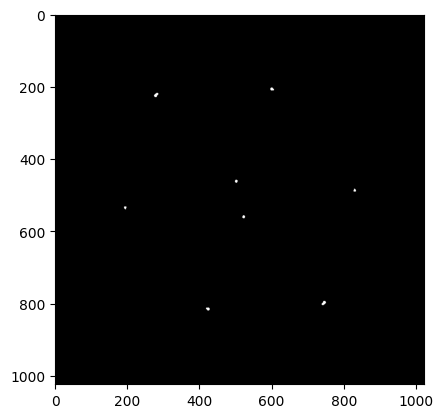

In [ ]:
plt.imshow(out, cmap='gray')

In [ ]:
out.max()

In [ ]:
base_path = 'Sample_Data/Test_Folder/FFT'
mask_path = 'Sample_Data/Test_Folder/Mask'

# for i in range(1, 10):
i = 9
tem_image_path = f"{base_path}/{i}.png"
fft_half = image_preprocessor(image_path, raw=False)
predicted_mask_path = predict_fft_mask(fmodel, fft_half)

fft_masked_path = 'masked_fft.png'
mask_fft(output_path=fft_masked_path)

gt_fft_masked_path = 'gt_masked_fft.png'
mask_fft(
    fft_mask_path=f'{mask_path}/{i}.png',
    # raw_fft_path= f'{base_path}/{i}.png',
    output_path=gt_fft_masked_path)

dummy = np.zeros((1024, 1024))

truth = PlotGraph(
    str(i), 0.037, dummy, df, i,
    predicted_mask=f'{mask_path}/{i}.png', # ground truth data
    masked_fft = gt_fft_masked_path, # masked ground truth
    eval=True
)

df_avg = PlotGraph(
    str(i), 0.037, dummy, df, i,
    predicted_mask=predicted_mask_path,
    masked_fft=fft_masked_path,
    eval=True
)
# metric
common_components = set(df_avg.index).intersection(set(truth.index))
component_score = len(common_components) / len(truth.index)

if component_score > 0:
    deviation = np.abs(df_avg.dspacing - truth.dspacing).dropna() / truth.dspacing
    deviation_score = (1 - deviation).dropna().mean()

    half_diagonal = np.abs(df_avg.half_diagonal - truth.half_diagonal) / truth.half_diagonal
    half_diagonal_score = (1 - half_diagonal).dropna().mean()
else:
    deviation_score = 0
    half_diagonal_score = 0
final_score = 0.75 * component_score + 0.15 * deviation_score + 0.10 * half_diagonal_score
print(final_score)

0.013196790540540541
0.013196790540540541
0.7349943564189095


In [ ]:
# @title

# for i in range(1, 10):
i = 6
image_path = f"Sample_Data/images/{i}.png"
fft_half = image_preprocessor(image_path) #f"{base_path}/{i}.png")
predicted_mask_path = predict_fft_mask(fmodel, fft_half)
fft_masked_path = mask_fft()

dft_shift = np.zeros((1024, 1024))

truth = PlotGraph(
    str(i), 0.037, dft_shift, df, i,
    predicted_mask=f'Sample_Data/fft_model/{i}.png',
    masked_fft = f'Sample_Data/fft_final/{i}.png',
    eval=True
)
df_avg = PlotGraph(
    str(i), 0.037, dft_shift, df, i,
    predicted_mask=predicted_mask_path,
    masked_fft=fft_masked_path,
    eval=True
)
# metric
common_components = set(df_avg.index).intersection(set(truth.index))
component_score = len(common_components) / len(truth.index)

deviation = np.abs(df_avg.dspacing - truth.dspacing) / truth.dspacing
deviation_score = (1 - deviation).mean()

half_diagonal = np.abs(df_avg.half_diagonal - truth.half_diagonal) / truth.half_diagonal
half_diagonal_score = (1 - half_diagonal).mean()

final_score = 0.75 * component_score + 0.15 * deviation_score + 0.10 * half_diagonal_score
print(final_score)

0.013196790540540541
0.013196790540540541
0.9970535854917351


In [ ]:
truth

,dspacing,distance,half_diagonal
components,,,
Li (011),0.240675,314.847979,7.798860
Li (112),0.146871,515.940974,5.978644
Li2O (113),0.088926,889.132869,7.052479
LiF (002),0.196117,386.380641,7.071068


In [ ]:
df_avg

,dspacing,distance,half_diagonal
components,,,
Li (002),0.178304,425.043122,3.489261
Li (112),0.150498,503.500248,4.000000
Li2CO3 (002),0.283341,267.437092,4.447552
Li2O (113),0.131325,577.012457,2.851707
LiF (002),0.194855,388.884623,2.569047
LiF (111),0.233872,324.006269,2.598076


In [ ]:
# img 6: unet_filters_256_dc_0.6635_l_0.0073: 0.9438207690746881
# img 1: unet_filters_256_dc_0.6635_l_0.0073: 0.9553211568836728
# img 6: unet_filters_512_dc_0.6545_l_0.0055: 0.9509919694232492
# img 1: unet_filters_512_dc_0.6545_l_0.0055: 0.957176076944396
# img 1: unet_leaky: 0.9820477368792317
# img 6: unet_leaky: 0.9962632376248206

# PRC

In [ ]:
!ls Sample_Data/Test_Folder/1024x1024px_1024filters_img/Predicted/

0.png  1.png  2.png  3.png  4.png  5.png  6.png  7.png	8.png


In [ ]:
base_path = 'Sample_Data/Rebuttal2'

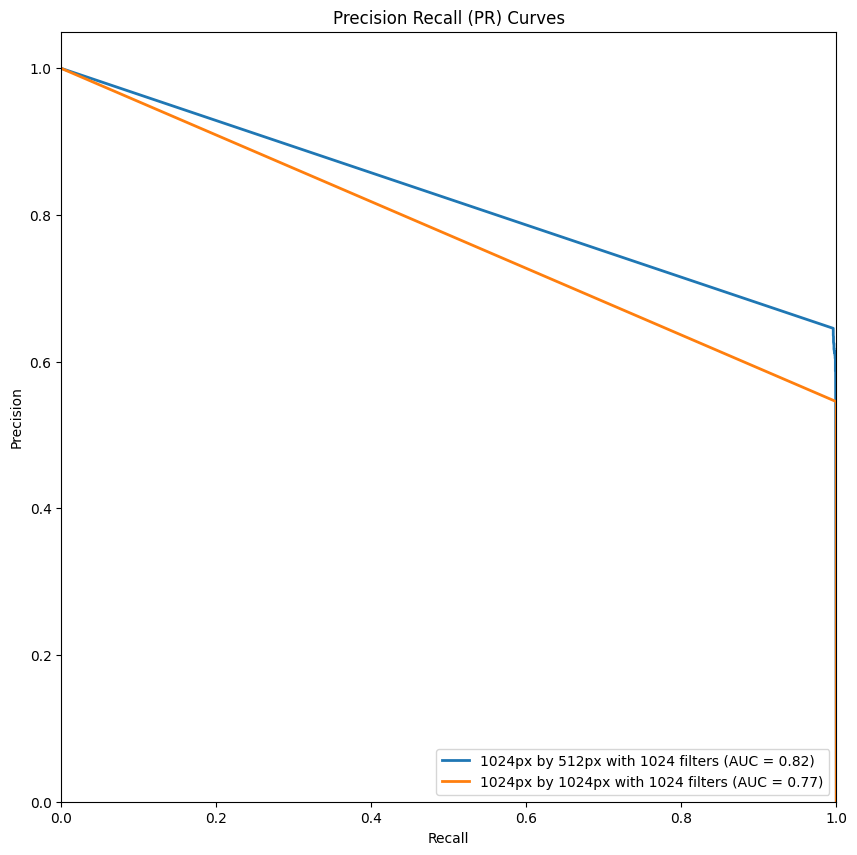

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Function to compute and plot prc curve
def compute_and_plot_prc(y_true_paths, model_pred_paths, model_labels):
    plt.figure(figsize=(10, 10))

    for model_pred_path, model_label, y_true_path in zip(model_pred_paths, model_labels, y_true_paths):
        y_trues, y_preds = [], []

        for image in range(0, 9):
            y_true = cv2.imread(f"{y_true_path}/{image}.png", cv2.IMREAD_GRAYSCALE)
            y_true = np.around(np.divide(y_true, 255, casting='same_kind'))
            y_pred = cv2.imread(f"{model_pred_path}/{image}.png", cv2.IMREAD_GRAYSCALE)
            y_pred = np.divide(y_pred, 255, casting='same_kind')
            # Flatten the arrays
            y_trues.extend(y_true.flatten().tolist())
            y_preds.extend(y_pred.flatten().tolist())

        # Calculate the false positive rate, true positive rate, and thresholds
        precision, recall, _ = precision_recall_curve(y_trues, y_preds)

        # Calculate the area under the curve (AUC)
        prc_auc = auc(recall,  precision)

        # Plot the prc curve for the current model
        plt.plot(recall, precision, lw=2, label=f'{model_label} (AUC = {prc_auc:.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall (PR) Curves')
    plt.legend(loc="lower right")
    plt.savefig(f"{base_path}/prc_curve.png")
    plt.show()
# Sample paths and labels
y_true_paths = [f'{base_path}/1024x512px_1024filters/Ground', f'{base_path}/1024x1024px_1024filters/Ground'] #, f'{base_path}/1024x512px_2048filters/Ground']
model_pred_paths = [f'{base_path}/1024x512px_1024filters/Predicted', f'{base_path}/1024x1024px_1024filters/Predicted'] # ,  f'{base_path}/1024x512px_2048filters/Predicted']
model_labels = ['1024px by 512px with 1024 filters', '1024px by 1024px with 1024 filters'] #, '1024px by 512px with 2048 filters']

# Compute and plot prc curves
compute_and_plot_prc(y_true_paths, model_pred_paths, model_labels)

# ROC

In [ ]:
!ls Sample_Data/Test_Folder/1024x1024px_1024filters_img/Predicted/

0.png  1.png  2.png  3.png  4.png  5.png  6.png  7.png	8.png


In [ ]:
base_path = 'Rebuttal2'

In [ ]:
!ls Rebuttal2

1024_512px.png		 1024x512px_1024filters  CNN_1024x512px  prc_curve.png	      roc_curve.png
1024x1024px_1024filters  1024x512px_2048filters  CNN.png	 Rebuttal_Images.zip


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Sample actual and predicted binary values

def compute_rates(y_true_path, y_pred_path):
    y_trues, y_preds = [], []

    for image in range(0, 9):
        y_true = cv2.imread(f"{y_true_path}/{image}.png", cv2.IMREAD_GRAYSCALE)
        y_true = np.around(np.divide(y_true, 255, casting='same_kind'))
        y_pred = cv2.imread(f"{y_pred_path}/{image}.png", cv2.IMREAD_GRAYSCALE)
        y_pred = np.divide(y_pred, 255, casting='same_kind')

        # Flatten the arrays
        y_trues.extend(y_true.flatten().tolist())
        y_preds.extend(y_pred.flatten().tolist())

    # Convert the lists to numpy arrays
    y_trues = np.array(y_trues)
    y_preds = np.array(y_preds)

    # Calculate the false positive rate, true positive rate, and thresholds
    fpr, tpr, _ = roc_curve(y_trues, y_preds)
    print(fpr, tpr)
    # Calculate the area under the curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('roc_curve.png')
    plt.show()

[0.00000000e+00 5.90000280e-04 6.00710206e-04 6.06648383e-04
 6.10253704e-04 6.14919415e-04 6.17146231e-04 6.18418697e-04
 6.21387786e-04 6.23084408e-04 6.24993107e-04 6.26159535e-04
 6.28704468e-04 6.29870896e-04 6.30931284e-04 6.32097712e-04
 6.33370178e-04 6.34324528e-04 6.34854723e-04 6.35596995e-04
 6.36657383e-04 6.38247966e-04 6.39414394e-04 6.40262705e-04
 6.40792899e-04 6.42065366e-04 6.42171405e-04 6.43655949e-04
 6.44292182e-04 6.45246532e-04 6.45776726e-04 6.46412959e-04
 6.46837115e-04 6.47367309e-04 6.48003543e-04 6.48215620e-04
 6.48533737e-04 6.49594126e-04 6.50018281e-04 6.50230359e-04
 6.50336398e-04 6.50760553e-04 6.51290748e-04 6.51502825e-04
 6.52457175e-04 6.52987369e-04 6.54259836e-04 6.54471914e-04
 6.54790030e-04 6.55002108e-04 6.56062497e-04 6.56274575e-04
 6.56592691e-04 6.56804769e-04 6.57228924e-04 6.57441002e-04
 6.57971196e-04 6.58077235e-04 6.58395352e-04 6.58607430e-04
 6.59031585e-04 6.59561780e-04 6.59667818e-04 6.60516129e-04
 6.61046324e-04 6.613644

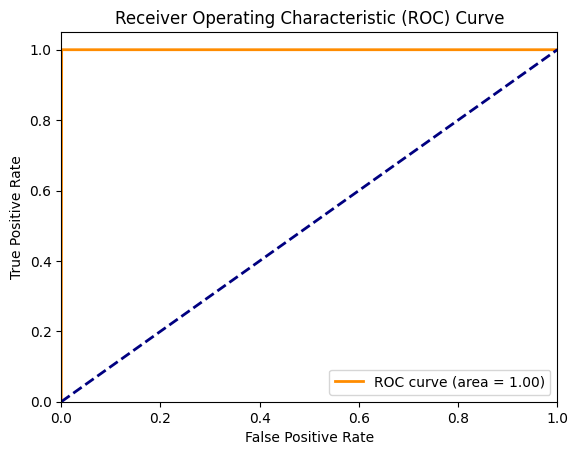

In [ ]:
y = compute_rates(f'{base_path}/1024x1024px_1024filters/Ground', f'{base_path}/1024x1024px_1024filters/Predicted')

[0.00000000e+00 3.87466036e-04 3.95524990e-04 4.01039011e-04
 4.04008100e-04 4.06977188e-04 4.10582510e-04 4.11854976e-04
 4.13339520e-04 4.17156920e-04 4.19277697e-04 4.20550164e-04
 4.21186397e-04 4.22246786e-04 4.22883019e-04 4.23943407e-04
 4.24155485e-04 4.24579641e-04 4.25427952e-04 4.25852107e-04
 4.27124574e-04 4.27336651e-04 4.27760807e-04 4.28609118e-04
 4.29245351e-04 4.29669507e-04 4.29881584e-04 4.30305740e-04
 4.30941973e-04 4.31154051e-04 4.32002362e-04 4.32638595e-04
 4.32850673e-04 4.34759372e-04 4.34971450e-04 4.36031839e-04
 4.36880150e-04 4.37304305e-04 4.37516383e-04 4.37940538e-04
 4.38152616e-04 4.38788849e-04 4.39213005e-04 4.40061316e-04
 4.40697549e-04 4.41121705e-04 4.41970016e-04 4.42182093e-04
 4.42606249e-04 4.43030404e-04 4.43030404e-04 4.43454560e-04
 4.43878715e-04 4.44727026e-04 4.45575337e-04 4.45999493e-04
 4.45999493e-04 4.46635726e-04 4.47059881e-04 4.47484037e-04
 4.47696115e-04 4.48120270e-04 4.48756503e-04 4.48968581e-04
 4.50241048e-04 4.506652

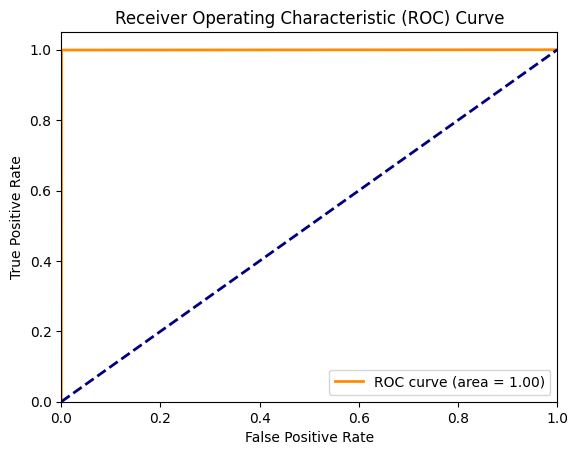

In [ ]:
y = compute_rates(f'{base_path}/1024x512px_1024filters/Ground', f'{base_path}/1024x512px_1024filters/Predicted')

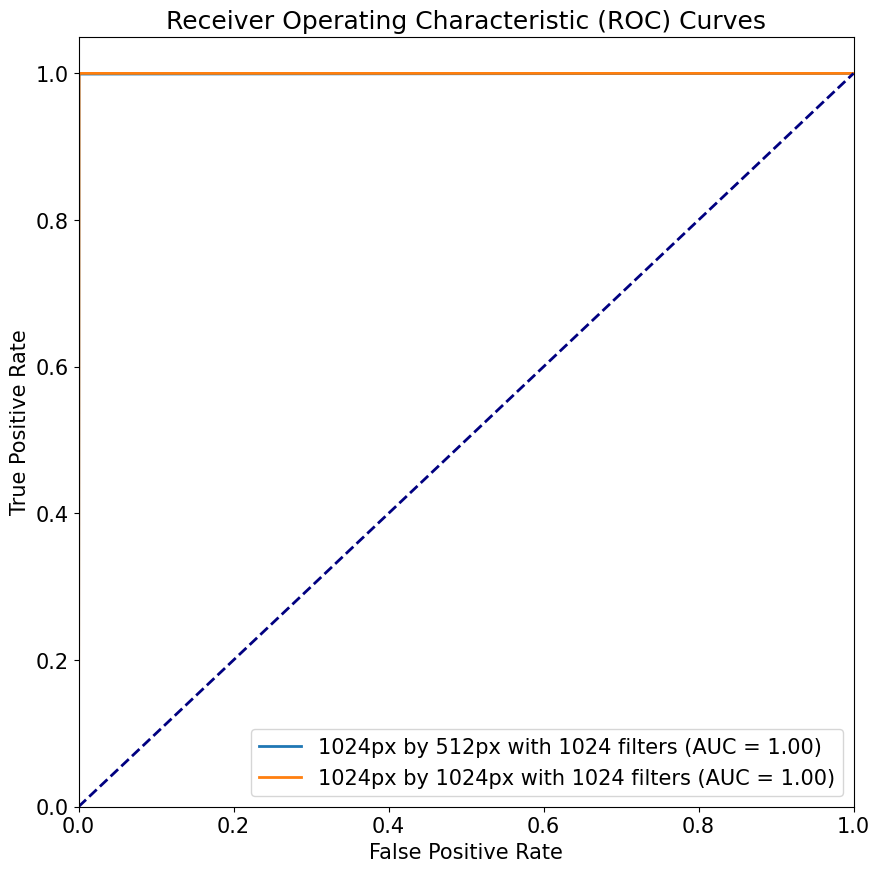

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to compute and plot ROC curve
def compute_and_plot_roc(y_true_paths, model_pred_paths, model_labels):
    plt.figure(figsize=(10, 10))

    for model_pred_path, model_label, y_true_path in zip(model_pred_paths, model_labels, y_true_paths):
        y_trues, y_preds = [], []

        for image in range(0, 9):
            y_true = cv2.imread(f"{y_true_path}/{image}.png", cv2.IMREAD_GRAYSCALE)
            y_true = np.around(np.divide(y_true, 255, casting='same_kind'))
            y_pred = cv2.imread(f"{model_pred_path}/{image}.png", cv2.IMREAD_GRAYSCALE)
            y_pred = np.divide(y_pred, 255, casting='same_kind')

            # Flatten the arrays
            y_trues.extend(y_true.flatten().tolist())
            y_preds.extend(y_pred.flatten().tolist())

        # Convert the lists to numpy arrays
        y_trues = np.array(y_trues)
        y_preds = np.array(y_preds)

        # Calculate the false positive rate, true positive rate, and thresholds
        fpr, tpr, _ = roc_curve(y_trues, y_preds)

        # Calculate the area under the curve (AUC)
        roc_auc = auc(fpr, tpr)

        # Plot the ROC curve for the current model
        plt.plot(fpr, tpr, lw=2, label=f'{model_label} (AUC = {roc_auc:.2f})')

    # Plot the diagonal line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.rcParams.update({'font.size': 15})
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    #plt.tick_params(axis='x', labelsize=10)
    plt.savefig(f"{base_path}/roc_curve.png")
    plt.show()
# Sample paths and labels
y_true_paths = [f'{base_path}/1024x512px_1024filters/Ground', f'{base_path}/1024x1024px_1024filters/Ground'] #, f'{base_path}/1024x512px_2048filters/Ground']
model_pred_paths = [f'{base_path}/1024x512px_1024filters/Predicted', f'{base_path}/1024x1024px_1024filters/Predicted'] #,  f'{base_path}/1024x512px_2048filters/Predicted']
model_labels = ['1024px by 512px with 1024 filters', '1024px by 1024px with 1024 filters'] #, '1024px by 512px with 2048 filters']

# Compute and plot ROC curves
compute_and_plot_roc(y_true_paths, model_pred_paths, model_labels)

In [ ]:
import cv2
import numpy as np
path = f'{base_path}/1024x512px_1024filters/Predicted/8.png'
y = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
np.unique(y, return_counts=True)

(array([  0,   1,   2,   3,   5,   6,   8,  11,  12,  13,  16,  17,  25,
         26,  32,  38,  43,  52,  93,  96, 103, 117, 121, 125, 138, 144,
        150, 166, 167, 169, 178, 179, 183, 201, 206, 209, 210, 211, 216,
        217, 227, 233, 243, 246, 250, 251, 252, 253, 254, 255], dtype=uint8),
 array([523638,      2,      2,      2,      1,      2,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,
             1,      2,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      2,      1,      1,      1,      1,
             1,      2,      1,      1,      1,      1,      1,      1,
             2,      1,      1,      1,      2,      5,      2,      5,
             2,    583]))

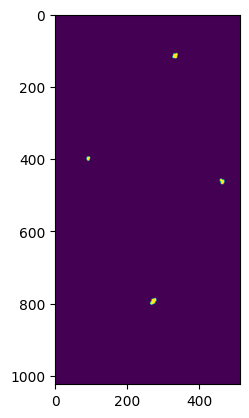

In [ ]:
plt.imshow(y)

In [ ]:
path = f'{base_path}/1024x512px_1024filters/Ground/8.png'
yg = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
np.unique(yg, return_counts=True)

(array([  0, 255], dtype=uint8), array([523854,    434]))

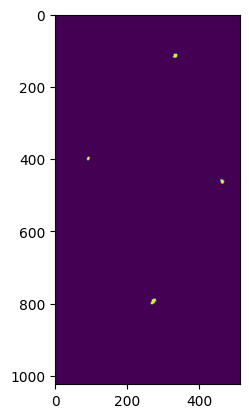

In [ ]:
plt.imshow(yg)

# Other Metrics

## Dice Coefficient 1024x512px

In [ ]:
def dice_coefficient(y_true, y_pred):
    # Flatten the tensors
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), dtype=tf.float32)

    # Compute the intersection and the sum of the two tensors
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    # Compute Dice Coefficient
    dice = (2. * intersection + 1e-5) / (union + 1e-5)

    return dice

In [ ]:
gpath = f'{base_path}/1024x512px_1024filters/Ground'
path = f'{base_path}/1024x512px_1024filters/Predicted'

In [ ]:
dice_scores = []
for i in range(9):
    y_true = cv2.imread(f"{gpath}/{i}.png", cv2.IMREAD_GRAYSCALE)
    y_pred = cv2.imread(f"{path}/{i}.png", cv2.IMREAD_GRAYSCALE)
    y_true = np.around(np.divide(y_true, 255, casting='same_kind'))
    y_pred = np.divide(y_pred, 255, casting='same_kind')
    dicey = dice_coefficient(y_true, y_pred)
    dice_scores.append(dicey)
    print(f"{i}: {dicey}")

0: 0.6609832644462585
1: 0.8126571178436279
2: 0.7847593426704407
3: 0.8310162425041199
4: 0.7752816677093506
5: 0.79229736328125
6: 0.7278411984443665
7: 0.5221672058105469
8: 0.816831111907959


In [ ]:
np.mean(dice_scores)

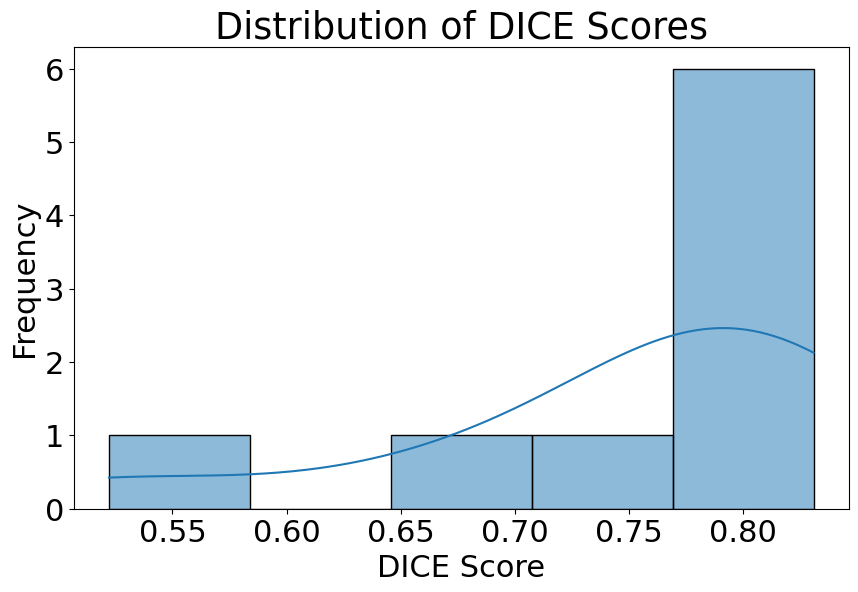

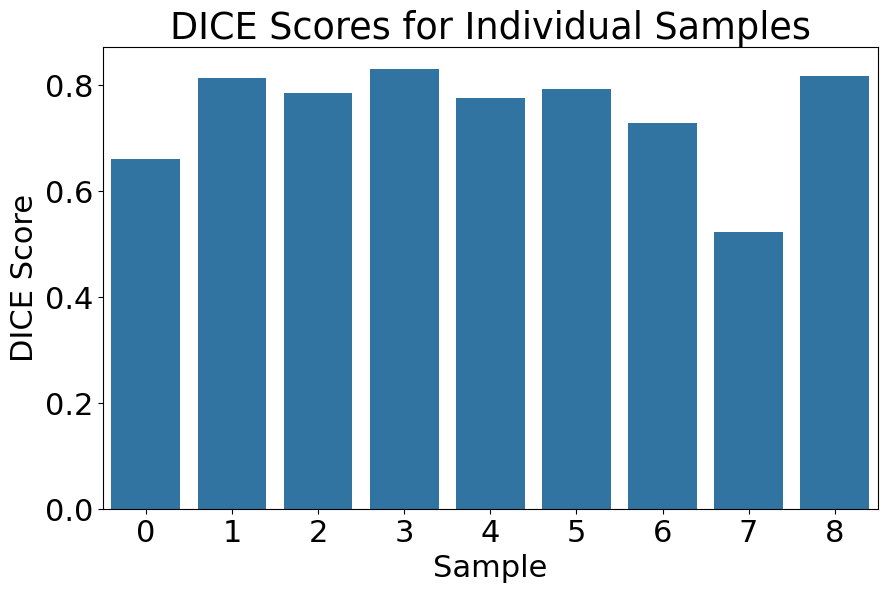

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.rcParams.update({'font.size': 22})
dice_scores = np.array(dice_scores)

# Histogram for DICE scores
plt.figure(figsize=(10, 6))
sns.histplot(dice_scores, kde=True)
plt.title('Distribution of DICE Scores')
plt.xlabel('DICE Score')
plt.ylabel('Frequency')
plt.show()

# Bar plot for individual sample metrics

plt.figure(figsize=(10, 6))
sns.barplot(x=range(len(dice_scores)), y=dice_scores)
plt.title('DICE Scores for Individual Samples')
plt.xlabel('Sample')
plt.ylabel('DICE Score')
plt.show()

## Dice Coefficient 1024x1024px

In [ ]:
def dice_coefficient(y_true, y_pred):
    # Flatten the tensors
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), dtype=tf.float32)

    # Compute the intersection and the sum of the two tensors
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    # Compute Dice Coefficient
    dice = (2. * intersection + 1e-5) / (union + 1e-5)

    return dice

In [ ]:
gpath = f'{base_path}/1024x1024px_1024filters/Ground'
path = f'{base_path}/1024x1024px_1024filters/Predicted'

In [ ]:
dice_scores = []
for i in range(9):
    y_true = cv2.imread(f"{gpath}/{i}.png", cv2.IMREAD_GRAYSCALE)
    y_pred = cv2.imread(f"{path}/{i}.png", cv2.IMREAD_GRAYSCALE)
    y_true = np.around(np.divide(y_true, 255, casting='same_kind'))
    y_pred = np.divide(y_pred, 255, casting='same_kind')
    dicey = dice_coefficient(y_true, y_pred)
    dice_scores.append(dicey)
    print(f"{i}: {dicey}")

0: 0.6816518306732178
1: 0.7335794568061829
2: 0.38725584745407104
3: 0.8260090947151184
4: 0.7367826700210571
5: 0.5876210331916809
6: 0.698803722858429
7: 0.651861846446991
8: 0.7444640398025513


In [ ]:
np.mean(dice_scores)

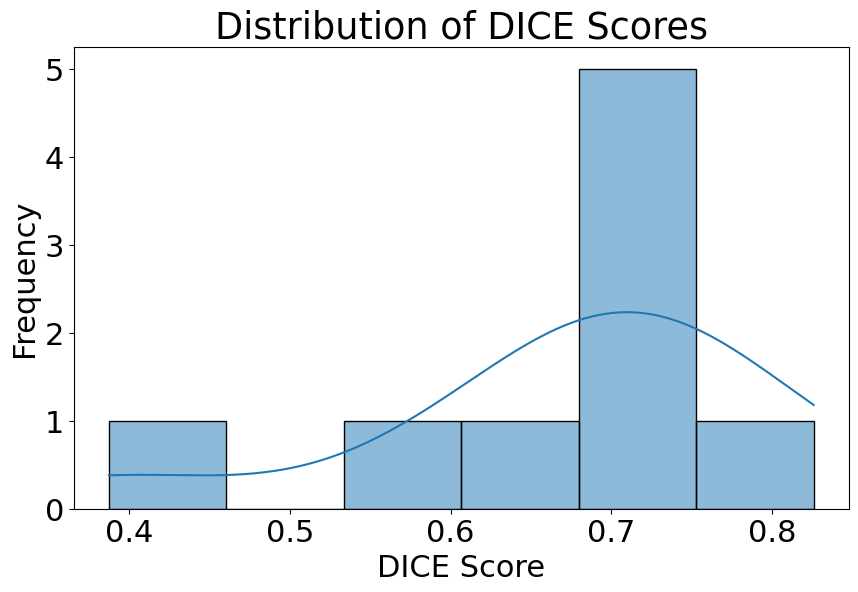

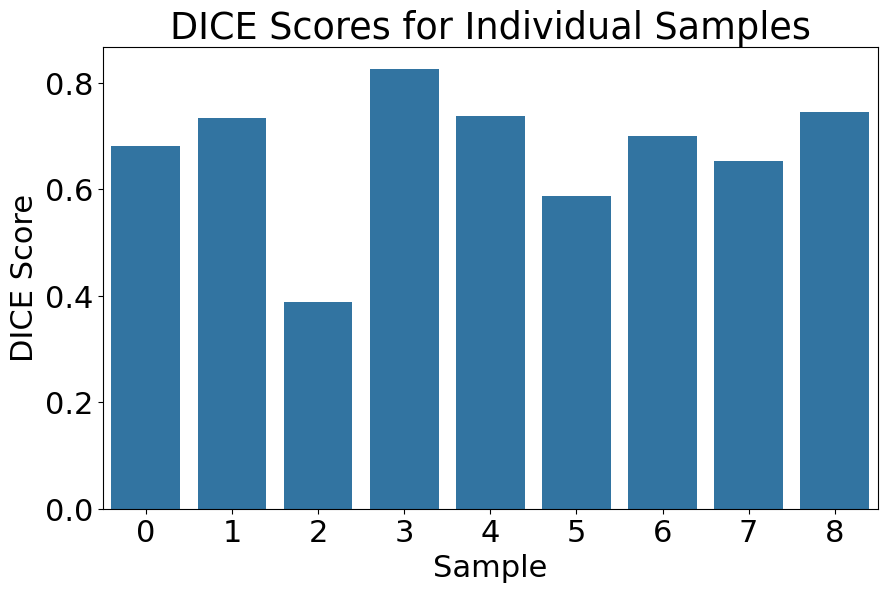

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams.update({'font.size': 22})

dice_scores = np.array(dice_scores)

# Histogram for DICE scores
plt.figure(figsize=(10, 6))
sns.histplot(dice_scores, kde=True)
plt.title('Distribution of DICE Scores')
plt.xlabel('DICE Score')
plt.ylabel('Frequency')
plt.show()

# Bar plot for individual sample metrics

plt.figure(figsize=(10, 6))
sns.barplot(x=range(len(dice_scores)), y=dice_scores)
plt.title('DICE Scores for Individual Samples')
plt.xlabel('Sample')
plt.ylabel('DICE Score')
plt.show()

## Dice Coefficient 1024x512px CNN

In [ ]:
def dice_coefficient(y_true, y_pred):
    # Flatten the tensors
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), dtype=tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), dtype=tf.float32)

    # Compute the intersection and the sum of the two tensors
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    # Compute Dice Coefficient
    dice = (2. * intersection + 1e-5) / (union + 1e-5)

    return dice

In [ ]:
gpath = f'{base_path}/CNN_1024x512px/Ground'
path = f'{base_path}/CNN_1024x512px/Predicted'

In [ ]:
dice_scores = []
for i in range(9):
    y_true = cv2.imread(f"{gpath}/{i}.png", cv2.IMREAD_GRAYSCALE)
    y_pred = cv2.imread(f"{path}/{i}.png", cv2.IMREAD_GRAYSCALE)
    y_true = np.around(np.divide(y_true, 255, casting='same_kind'))
    y_pred = np.divide(y_pred, 255, casting='same_kind')
    dicey = dice_coefficient(y_true, y_pred)
    dice_scores.append(dicey)
    print(f"{i}: {dicey}")

0: 0.3962102234363556
1: 0.4917571544647217
2: 0.4873766303062439
3: 0.36760205030441284
4: 0.58470618724823
5: 0.6071207523345947
6: 0.5083690881729126
7: 0.5741363763809204
8: 0.5816174149513245


In [ ]:
np.mean(dice_scores)

0.5109885

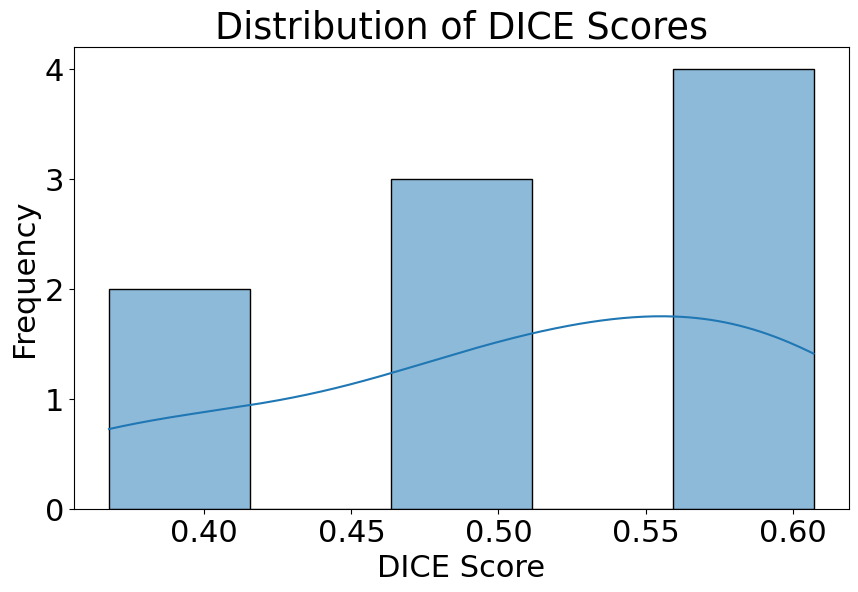

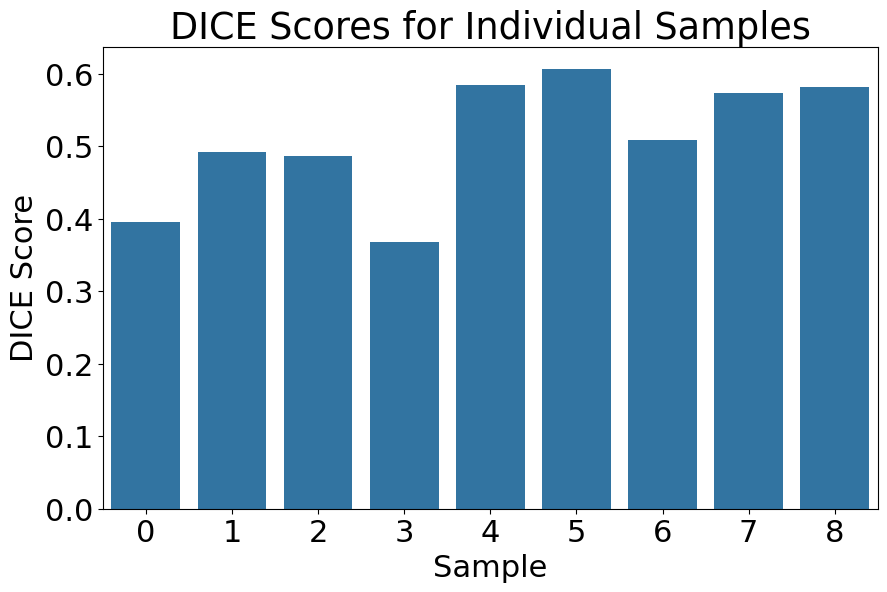

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams.update({'font.size': 22})

dice_scores = np.array(dice_scores)

# Histogram for DICE scores
plt.figure(figsize=(10, 6))
sns.histplot(dice_scores, kde=True)
plt.title('Distribution of DICE Scores')
plt.xlabel('DICE Score')
plt.ylabel('Frequency')
plt.show()

# Bar plot for individual sample metrics

plt.figure(figsize=(10, 6))
sns.barplot(x=range(len(dice_scores)), y=dice_scores)
plt.title('DICE Scores for Individual Samples')
plt.xlabel('Sample')
plt.ylabel('DICE Score')
plt.show()

## Confusion Matrix Heatmap

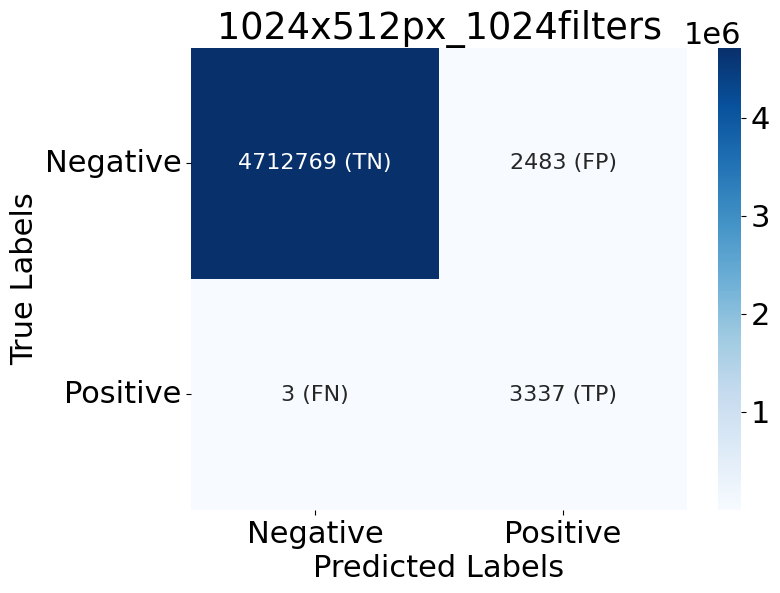

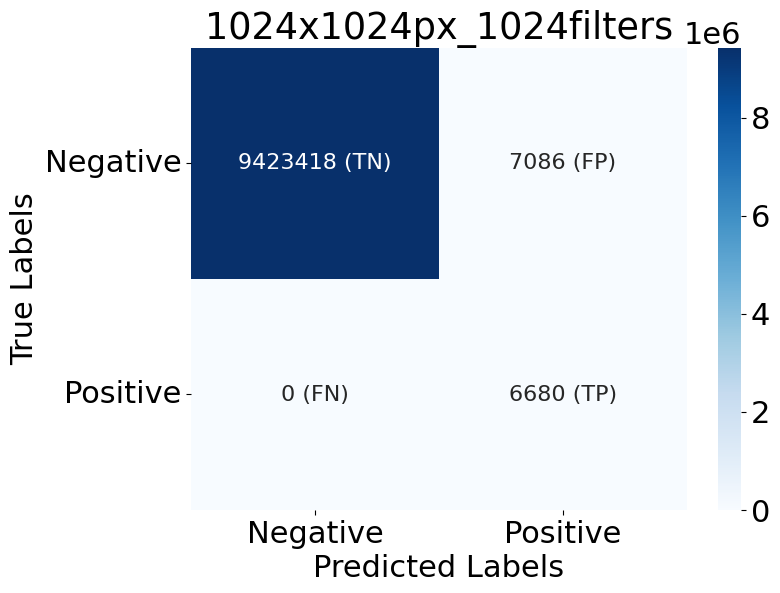

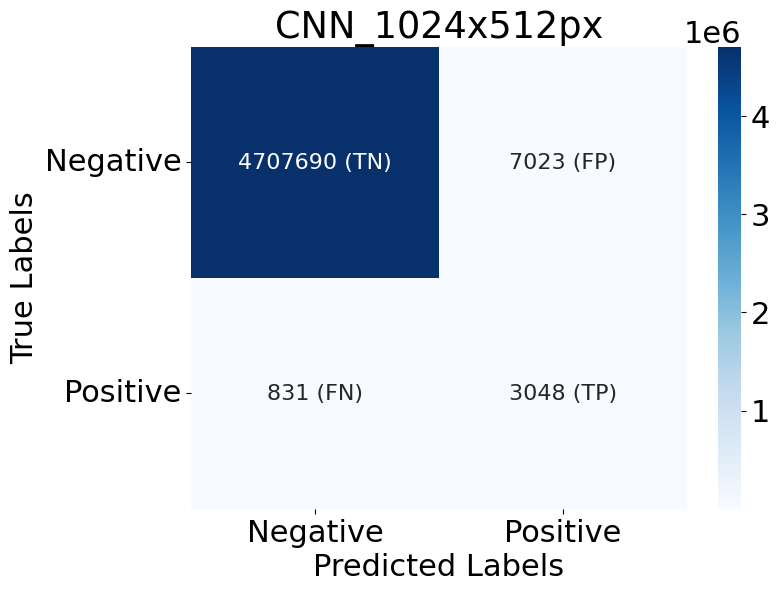

In [ ]:
from sklearn.metrics import confusion_matrix

models = ['1024x512px_1024filters', '1024x1024px_1024filters','CNN_1024x512px']
plt.rcParams.update({'font.size': 22})
for model in models:
    y_trues, y_preds = [], []
    y_true_path = f'{base_path}/{model}/Ground'
    y_pred_path = f'{base_path}/{model}/Predicted'

    for image in range(0, 9):
        y_true = cv2.imread(f"{y_true_path}/{image}.png", cv2.IMREAD_GRAYSCALE)
        y_true = np.around(np.divide(y_true, 255, casting='same_kind'))
        y_pred = cv2.imread(f"{y_pred_path}/{image}.png", cv2.IMREAD_GRAYSCALE)
        y_pred = np.divide(y_pred > 0, 1, casting='same_kind')

        # Flatten the arrays
        y_trues.extend(y_true.flatten().tolist())
        y_preds.extend(y_pred.flatten().tolist())

    # Convert the lists to numpy arrays
    y_trues = np.array(y_trues)
    y_preds = np.array(y_preds)

    cm = confusion_matrix(y_trues, y_preds)

    # Create the combined annotation matrix
    labels = np.array([['TN', 'FP'], ['FN', 'TP']])
    annot = np.empty_like(cm).astype(str)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]} ({labels[i, j]})'

    # Create a heatmap using Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', annot_kws={"size": 16})

    # Customize plot
    plt.title(f'{model}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'], rotation=0)
    plt.show()